# Set tensorflow version to 2.x

In [ ]:
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.0


# Import AttentionLayer and Required Libraries

In [ ]:
from attention import AttentionLayer

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load dataset from Google Drive

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List .csv files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains '.csv' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

In [ ]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# shareable link
file_id = '1_QvnC-T_IGoqbIdg5_ofu8pJPYU_616e'
file_dataset = drive.CreateFile({'id': file_id})
file_dataset.GetContentFile('dataset_medium_article.csv')

In [ ]:
data = pd.read_csv('dataset_medium_article.csv')
# data = pd.read_csv('dataset_medium_article.csv', nrows=100000)

In [ ]:
data = data[{"title", "text"}]

Drop duplicated values and NA values

In [ ]:
#dropping duplicates
data.drop_duplicates(subset=['title'], inplace=True)
#dropping na
data.dropna(axis=0, inplace=True)

In [ ]:
# raw_title = data.drop_duplicates(['postId'])[['postId','title']]
# raw_title.head(100)
# print(raw_title.size)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70275 entries, 0 to 279572
Data columns (total 2 columns):
text     70275 non-null object
title    70275 non-null object
dtypes: object(2)
memory usage: 1.6+ MB


# Preprocessing

In [ ]:
contraction_mapping = {
  "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
  "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
  "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
  "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
  "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
  "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
  "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
  "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
  "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
  "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
  "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
  "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
  "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
  "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
  "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
  "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
  "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
  "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
  "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
  "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
  "you're": "you are", "you've": "you have"
}

**Steps**

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

## Text Cleaning

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
  newString = text.lower()
  newString = BeautifulSoup(newString, "lxml").text
  newString = re.sub(r'\([^)]*\)', '', newString)
  newString = re.sub('"','', newString)
  newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
  newString = re.sub(r"'s\b","",newString)
  newString = re.sub("[^a-zA-Z]", " ", newString) 
  tokens = [w for w in newString.split() if not w in stop_words]
  long_words=[]
  for i in tokens:
    if len(i)>=3:                  #removing short word
      long_words.append(i)   
  return (" ".join(long_words)).strip()

#Call the above function
cleaned_text = []
for t in data['text']:
  cleaned_text.append(text_cleaner(t))

In [ ]:
cleaned_text[:10]

['private business government blockchain major private company implements blockchain artificial intelligence internet things optimize improve high technology workflow representatives major state structure country like experiment much decide use work conclude agreement giant ideal example interaction private business state regarding blockchain think even better story real south korea local customs office signed respective partnership agreement samsung believe near term development blockchain built examples cooperation world best technological decisions copied supersonic speed one cannot remain behind trends long confident blockchain crypto technologies soon adopted around world century would strange searching telephone booth make call anywhere planet one click gadget https www coindesk com korea taps samsungs blockchain tech fight customs fraud',
 'epq draft https upload wikimedia org wikipedia commons sanko seisakusyo tin wind tiny smoking spaceman robots close jpg introduction automat

## Title Cleaning

In [ ]:
def title_cleaner(text):
  newString = re.sub('"','', text)
  newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
  newString = re.sub(r"'s\b","",newString)
  newString = re.sub("[^a-zA-Z]", " ", newString)
  newString = newString.lower()
  tokens=newString.split()
  newString=''
  for i in tokens:
    if len(i)>1:                                 
      newString=newString+i+' '  
  return newString

#Call the above function
cleaned_title = []
for t in data['title']:
    cleaned_title.append(title_cleaner(t))

In [ ]:
cleaned_title[:10]

['private business government and blockchain ',
 'epq draft words ',
 'ascent of data science sas and big data analyst trainings programs ',
 'can robot love us better than another human can ',
 'big data ai and iot use cases ',
 'oracle oracle could day ',
 'artificial intelligence is the next frontier ',
 'aidoc gets ce mark for deep learning solution ',
 'ai and it impact on the world ',
 'the meta model and meta meta model of deep learning ']

In [ ]:
mData = {
  'cleaned_title': cleaned_title, 
  'cleaned_text': cleaned_text
} 

# print(len(cleaned_title))
# print(len(cleaned_text))

cleaned_data = pd.DataFrame(mData)

print(len(cleaned_data['cleaned_text']))
print(len(cleaned_data['cleaned_title']))

70275
70275


In [ ]:
# cleaned_data.replace('', np.nan, inplace=True)
# cleaned_data.dropna(axis=0, inplace=True)

print(len(cleaned_data['cleaned_text']))
print(len(cleaned_data['cleaned_title']))

cleaned_data['cleaned_title'] = cleaned_data['cleaned_title'].apply(lambda x : '_START_ '+ x + ' _END_')

70275
70275


In [ ]:
# Peek the first 5
for i in range(5):
  print("Text:",cleaned_data['cleaned_text'][i])
  print("Title:",cleaned_data['cleaned_title'][i])
  print("\n")

Text: private business government blockchain major private company implements blockchain artificial intelligence internet things optimize improve high technology workflow representatives major state structure country like experiment much decide use work conclude agreement giant ideal example interaction private business state regarding blockchain think even better story real south korea local customs office signed respective partnership agreement samsung believe near term development blockchain built examples cooperation world best technological decisions copied supersonic speed one cannot remain behind trends long confident blockchain crypto technologies soon adopted around world century would strange searching telephone booth make call anywhere planet one click gadget https www coindesk com korea taps samsungs blockchain tech fight customs fraud
Title: _START_ private business government and blockchain  _END_


Text: epq draft https upload wikimedia org wikipedia commons sanko seisak

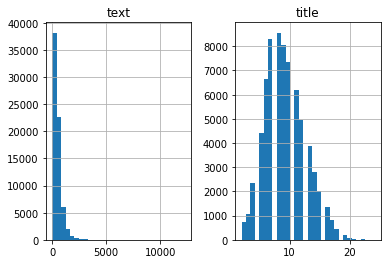

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for i in cleaned_data['cleaned_text']:
  text_word_count.append(len(i.split()))

for i in cleaned_data['cleaned_title']:
  title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'title':title_word_count, 'text':text_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in cleaned_data['cleaned_title']:
  if(len(i.split())<=25):
    cnt=cnt+1
print(cnt/len(cleaned_data['cleaned_title']))

1.0


In [ ]:
max_len_text=500
max_len_title=25

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_data['cleaned_text'],cleaned_data['cleaned_title'],test_size=0.1,random_state=0,shuffle=True) 

# Preparing the Tokenizer

Text Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
x_voc_size

345295

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
  tot_cnt=tot_cnt+1
  tot_freq=tot_freq+value
  if(value<thresh):
    cnt=cnt+1
    freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.38082329840658
Total Coverage of rare words: 1.074351930769193


Title Tokenizer

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_title, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_title, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
y_voc_size

31451

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
  tot_cnt=tot_cnt+1
  tot_freq=tot_freq+value
  if(value<thresh):
    cnt=cnt+1
    freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.69316375198729
Total Coverage of rare words: 7.084119187330973


# Model Building

In [ ]:
from keras import backend as K 
# K.clear_session() 
# def create_model():
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

# return model


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 500)     172647500   input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 500), ( 2002000     embedding[0][0]                  
_____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
# import os
# import tensorflow as tf

# # TF 1.x
# resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

# TF 2.0
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_host(resolver.master())
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

# with strategy.scope():
#   model = create_model()
#   model.compile(
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
#     loss=tf.keras.losses.sparse_categorical_crossentropy,
#     metrics=[tf.keras.metrics.sparse_categorical_accuracy]
#   )


In [ ]:
number_of_epoch = 10
number_of_batch = 110

history=model.fit(
  [x_tr, y_tr[:,:-1]], 
  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
  epochs=number_of_epoch,
  callbacks=[es],
  batch_size=number_of_batch, 
  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 63247 samples, validate on 7028 samples
Epoch 1/10
63247/63247 [==============================] - 2318s 37ms/sample - loss: 2.2251 - val_loss: 1.8789
Epoch 2/10
63247/63247 [==============================] - 2291s 36ms/sample - loss: 1.9078 - val_loss: 1.7092
Epoch 3/10
63247/63247 [==============================] - 2288s 36ms/sample - loss: 1.7185 - val_loss: 1.5748
Epoch 4/10
63247/63247 [==============================] - 2288s 36ms/sample - loss: 1.5552 - val_loss: 1.5074
Epoch 5/10
63247/63247 [==============================] - 2293s 36ms/sample - loss: 1.4093 - val_loss: 1.3911
Epoch 6/10
 6380/63247 [==>...........................] - ETA: 33:41 - loss: 1.2907

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
  [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
  [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,1))

  # Chose the 'start' word as the first word of the target sequence
  target_seq[0, 0] = target_word_index['start']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    # print(sampled_token_index)
    if (sampled_token_index == 0):
        break
    sampled_token = reverse_target_word_index[sampled_token_index]
    # print(sampled_token)

    if(sampled_token!='end'):
      decoded_sentence += ' '+sampled_token

      # Exit condition: either hit max length or find stop word.
      if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_title-1)):
        stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [ ]:
def seq2title(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original title:",seq2title(y_val[i]))
  print("Predicted title:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: applications source business insider sense might definitively know come surely coming certainly going big jurassic park effect done well experience amazing deeply satisfying done really well general fear could turn runaway train exactly accurate large applications assistant based programmed intent uncanny valley bot far realistically mimicking human behavior nuance may always exist regard evolution user interface precursor designers developers talk type user interface certainly form interact technology true point delineation occurs nlp enters prior user interface mirrored natural world experience earnestly digital technology evolves one question remained constant optimal user interface technology keyboard controls mouse wireless mouse evolution trended toward accessibility usability likewise grew quickly screen displays green text based prompts graphical user interface interaction branded icons universal directives recent tech triumph touch screen interface become expected norm